<a href="https://colab.research.google.com/github/raurica/Image-Forgery/blob/main/ImageForgery_not_KFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import os
from tensorflow import keras
from sklearn.metrics import classification_report
import seaborn as sn; sn.set(font_scale=1.4)
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dense
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

##Loading the dataset

In [29]:
fileId = drive.CreateFile({'id':'1pL6W3mN931TmmaCtMZsR0z1YuVfkvH4J'})
fileId.GetContentFile(fileId['title'])
print('Uploaded {}, id {}'.format(fileId['title'],fileId['id']))

Uploaded MICC-F220.zip, id 1pL6W3mN931TmmaCtMZsR0z1YuVfkvH4J


In [31]:
!unzip -q MICC-F220.zip
print('dataset unzipped')

replace MICC-F220/test_train_images/original/CRW_4809_scale.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
dataset unzipped


In [32]:
seed=13
np.random.seed(seed)

##Main variables

In [33]:
IMAGE_SIZE = (224,224)
EPOCHS = 50
BATCH_SIZE = 16

##Creating labels

In [34]:
class_names=['original','tampered']
class_name_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
print(class_name_label)

{'original': 0, 'tampered': 1}


##Load data

In [35]:
def load_data():
    DIRECTORY = r"/content/MICC-F220"
    CATEGORY = ["test_train_images","validation_images"]
    
    output = []
    
    for category in CATEGORY:
        path = os.path.join(DIRECTORY, category)
        images = []
        labels = []
        
        print("Loading {}".format(category))
        
        for folder in os.listdir(path):
            label = class_name_label[folder]
            
            for file in os.listdir(os.path.join(path, folder)):
                
                img_path = os.path.join(os.path.join(path,folder),file)
                
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype="float32")
        labels = np.array(labels, dtype="float32")
        
        #output.append((images,labels))
    return images,labels #output

In [36]:
def plot_accuracy_loss(history):

    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(12, 6))
    
    plt.subplots_adjust(hspace=0.6)
    # summarize history for accuracy
    
    
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy', size=20, fontweight="bold")
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Training', 'Validation'])
   
    # summarize history for loss
    
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss', size=20, fontweight="bold")
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Training', 'Validation'])
    
    plt.show()

In [37]:
images, labels = load_data()
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=1) 

"""
(train_images, train_labels), (test_images, test_labels) = load_data()
train_images, train_labels = shuffle(train_images, train_labels, random_state=seed)
"""

Loading test_train_images
Loading validation_images


'\n(train_images, train_labels), (test_images, test_labels) = load_data()\ntrain_images, train_labels = shuffle(train_images, train_labels, random_state=seed)\n'

##Preprocessing

In [38]:
# Normalize data
train_images = train_images / 255
test_images = test_images / 255

##Model and training

In [39]:
 
model = Sequential()
model.add(Conv2D(16, 1, activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(64, (3,3),1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3),1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(256, (3,3),1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(512, (3,3),1, activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(2,activation='softmax'))

#optim = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer="adam", 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

#model.summary()
history = model.fit(train_images, train_labels, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=(test_images,test_labels),
                    #validation_split=0.2,
                    shuffle=True,
                    verbose=1
                    )


Epoch 1/50
6/6 [==============================] - 1s 64ms/step - loss: 0.7091 - accuracy: 0.5682 - val_loss: 0.6812 - val_accuracy: 0.6818
Epoch 2/50
6/6 [==============================] - 0s 28ms/step - loss: 0.6944 - accuracy: 0.5000 - val_loss: 0.7400 - val_accuracy: 0.3182
Epoch 3/50
6/6 [==============================] - 0s 26ms/step - loss: 0.7010 - accuracy: 0.5455 - val_loss: 0.7059 - val_accuracy: 0.3182
Epoch 4/50
6/6 [==============================] - 0s 25ms/step - loss: 0.6864 - accuracy: 0.5455 - val_loss: 0.7325 - val_accuracy: 0.3182
Epoch 5/50
6/6 [==============================] - 0s 25ms/step - loss: 0.6900 - accuracy: 0.5455 - val_loss: 0.7519 - val_accuracy: 0.3182
Epoch 6/50
6/6 [==============================] - 0s 24ms/step - loss: 0.6895 - accuracy: 0.5455 - val_loss: 0.7008 - val_accuracy: 0.3182
Epoch 7/50
6/6 [==============================] - 0s 25ms/step - loss: 0.6901 - accuracy: 0.5455 - val_loss: 0.7098 - val_accuracy: 0.3182
Epoch 8/50
6/6 [===========

In [40]:
test_loss = model.evaluate(test_images, test_labels)

1/1 [==============================] - 0s 34ms/step - loss: 0.1470 - accuracy: 0.9091


In [41]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

print(classification_report(test_labels, pred_labels))

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83         7
         1.0       0.88      1.00      0.94        15

    accuracy                           0.91        22
   macro avg       0.94      0.86      0.89        22
weighted avg       0.92      0.91      0.90        22



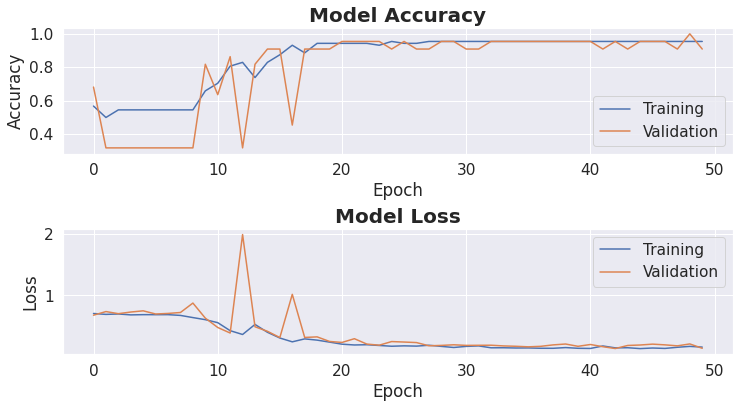

In [42]:
plot_accuracy_loss(history)

In [28]:
model.save('forgery_model_not_kfold_50ep.h5') 